In [1]:
import location as lc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
stopsdf = pd.read_csv("../get_stops_data/b20-stops-data/b20-north-stops-data.csv")
stopsdf.head()


,StopID,Name,AtStreet,BayNo,City,Lat,Long,OnStreet,Routes,WheelchairAccess
0,51202,WB HARRISON DR NS VICTORIA DR,VICTORIA DR,N,VANCOUVER,49.210673,-123.065781,HARRISON DR,020,True
1,51203,NB VICTORIA DR FS FRASERVIEW DR,FRASERVIEW DR,N,VANCOUVER,49.212765,-123.065964,VICTORIA DR,"020, N20",True
2,51204,NB VICTORIA DR FS E 61 AVE,E 61 AVE,N,VANCOUVER,49.214832,-123.065913,VICTORIA DR,"020, N20",True
3,51205,NB VICTORIA DR FS BRIGADOON AVE,BRIGADOON AVE,N,VANCOUVER,49.216910,-123.065874,VICTORIA DR,"020, N20",True
4,51206,NB VICTORIA DR FS UPLAND DR,UPLAND DR,N,VANCOUVER,49.218398,-123.065832,VICTORIA DR,"020, N20",True


### Init bus stop objects from data frame
The bus stops must be in physical order.

In [3]:
stops = []

# iterate through each stop and init BusStop objects
j = 0

for stop in stopsdf.iloc:
    connectedness = len(stop['Routes'].split(','))
    bstop = lc.BusStop(stop['Lat'], stop['Long'], stop['StopID'],[], j, connectedness)
    stops.append(bstop)
    j += 1


In [4]:
areadf = pd.read_csv("../stats-canada-data/DA.csv")
areadf.head()

,DAuid,DApop_2016,DAtdwell_2016,DAurdwell_2016,DAarea,DAir_2016,DArplamx,DArplamy,DArplat,DArplong,PRuid,CDcode,ADAcode,DAcode,ERcode,CCScode,CSDcode,CMAuid,CTname,CTcode
0,59150307,632,273,254,0.2994,0,4.025164e+06,2.004585e+06,49.287698,-123.026031,59,15,59,307,20,22,22,933,53.02,5286
1,59150308,501,223,203,0.1095,0,4.024986e+06,2.004256e+06,49.284329,-123.026065,59,15,59,308,20,22,22,933,53.02,5286
2,59150309,745,299,269,0.1118,0,4.024664e+06,2.004196e+06,49.282483,-123.029585,59,15,59,309,20,22,22,933,53.02,5286
3,59150310,536,310,283,0.1095,0,4.024866e+06,2.003949e+06,49.281378,-123.025534,59,15,59,310,20,22,22,933,53.02,5286
4,59150311,532,199,181,0.0810,0,4.024531e+06,2.003835e+06,49.279058,-123.028871,59,15,59,311,20,22,22,933,53.02,5286


In [5]:
areas = []

# iterate through each area and init Block objects
for area in areadf.iloc:
    area = lc.Block(area['DArplat'], area['DArplong'], area['DAuid'],int(area['DApop_2016']),int(area['DAurdwell_2016']), [])
    areas.append(area)

### For each stop we find neighboring areas within $x$ km

In [6]:
dist = 0.5
# find neighborhood for each stop
for stop in stops:
    stop.findNeighbors(areas, dist)

### Create a data frame for stops which contains StopID, Lat, Long and Connectedness

In [7]:
stopId = [stop.id for stop in stops]
lat = [stop.lat for stop in stops]
long = [stop.long for stop in stops]
conect = [stop.connectedness for stop in stops]
d = {'stopId':stopId, 'lat':lat, 'long':long, 'connectedness':conect}
stopVizDf = pd.DataFrame(data=d)
stopVizDf.head()

,stopId,lat,long,connectedness
0,51202,49.210673,-123.065781,1
1,51203,49.212765,-123.065964,2
2,51204,49.214832,-123.065913,2
3,51205,49.216910,-123.065874,2
4,51206,49.218398,-123.065832,2


### Create a data frame for all Areas which are in proximity to bus stops

In [8]:
route_areas_with_dups = []
# iterate though each stop and get areas,
# Since some stops share Areas this results in duplicates (it is supposed to be like that)
for stop in stops:
    route_areas_with_dups = route_areas_with_dups + stop.neighborhood

uniqueRouteAreas = set(route_areas_with_dups)

print('number of areas along the route:',len(uniqueRouteAreas))

areaId = [area.id for area in route_areas_with_dups]
lat = [area.lat for area in route_areas_with_dups]
long = [area.long for area in route_areas_with_dups]
popul = [area.pop for area in route_areas_with_dups]

d = {'areaId':areaId, 'lat':lat, 'long':long, 'pop':popul}
areaVizDf = pd.DataFrame(data=d)
areaVizDf.head()


number of areas along the route: 134


,areaId,lat,long,pop
0,59151209.0,49.210165,-123.069500,667
1,59151211.0,49.213535,-123.062329,584
2,59151214.0,49.208190,-123.061474,628
3,59151215.0,49.207338,-123.063235,543
4,59153799.0,49.211912,-123.062435,285


### For each area we find neighboring bus stops.

In [9]:
def get_max_stops_per_area(uniqueRouteAreas, stops):
    """ return an area with most stops in its Nb and size of Nb """
    mostStopsPerArea = 0
    area_with_most_stops = 0
    
    for area in uniqueRouteAreas:
        area.findNeighbors(stops,dist)
        stopsPerArea = len(area.neighborhood)

        if stopsPerArea > mostStopsPerArea:
            mostStopsPerArea = stopsPerArea
            area_with_most_stops = area
    
    return area, mostStopsPerArea

area, mostStopsPerArea = get_max_stops_per_area(uniqueRouteAreas, stops)
print('most stops per area:', mostStopsPerArea, ', block with most stops:', area)

most stops per area: 6 , block with most stops: block id:59153585.0


### For each stop we find competitor bus stops and compute weights

In [10]:
competDist = 0.3
for stop in stops:
    stop.findCompetitors(stops, competDist)
    stop.computeWeight()
    # set weight to 100 for start and end stops
    if stop.id == 51202 or stop.id == 61918:
        stop.weight = 100
    print(stop, ' competitors:',stop.competitors, 'weights:', stop.weight)

busStop id:51202  competitors: [busStop id:51203] weights: 100
busStop id:51203  competitors: [busStop id:51202, busStop id:51204] weights: 2
busStop id:51204  competitors: [busStop id:51203, busStop id:51205] weights: 2
busStop id:51205  competitors: [busStop id:51204, busStop id:51206] weights: 2
busStop id:51206  competitors: [busStop id:51205, busStop id:51207] weights: 2
busStop id:51207  competitors: [busStop id:51206] weights: 2
busStop id:51208  competitors: [busStop id:51209] weights: 2
busStop id:51209  competitors: [busStop id:51208, busStop id:51210] weights: 2
busStop id:51210  competitors: [busStop id:51209, busStop id:51211] weights: 2
busStop id:51211  competitors: [busStop id:51210, busStop id:51212] weights: 2
busStop id:51212  competitors: [busStop id:51211, busStop id:50652] weights: 2
busStop id:50652  competitors: [busStop id:51212, busStop id:50653] weights: 2
busStop id:50653  competitors: [busStop id:50652, busStop id:50654] weights: 2
busStop id:50654  competi

### Star formulating objective function.  
#### QUBO as Taylor series  
Let $C_j(r)$ be a neighborhood of a stop $j$ with radius $r$ then
\begin{align*}
f_j = \frac{Q_{jj}X_j}{1+\sum_{k\in C_j}X_k}.
\end{align*}

Put $x = \sum_{k\in C_j}X_k$.  
Taylor series with two term approx of $f_j$ at $k$ yields  
\begin{align*}
    f_j &\approx f(k) + f'(k)(x-k)\\
    \\
    &=\frac{1+2k}{(1+k)^2}Q_{jj}X_j - \frac{Q_{jj}X_jx}{(1+k)^2}.
\end{align*}
<br>
For best approximation when $r = 0.3$km set $k = \frac{|C_j|}{2}$.

In [15]:
# Define a distance function in meters
d = lambda X,Y: lc.kmDist(X,Y)*1000

def obj_func(X, uniqueRouteAreas, alpha, beta):
    """ Area oriented objective function """
    S = 0
    for area in uniqueRouteAreas:
        for stop in area.neighborhood:
            denom = 1
            # if a stop has stop competitors dive S_ij by denom
            if stop.competitors:
                for compet in stop.competitors:
#                     denom += X[compet.j]*d(area, compet)**(-beta)*compet.weight**alpha
                    denom += X[compet.j]

            S += area.pop*X[stop.j]*d(area,stop)**(-beta)*stop.weight**alpha/denom

    return S


def alt_obj_func(X, stops, alpha, beta):
    """ Stop oriented objective function. No p-constraint. """
    Z = 0
    # iterate though stops j
    for stop in stops:
        S_ij = stop.weight**alpha*X[stop.j]
        coef_j = 0
        denom = 1
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            coef_j += area.pop*d(area,stop)**(-beta)
        
        # compute denominator for X_j
        for compet in stop.competitors:
            denom += X[compet.j]
    
        S_ij *= coef_j/denom
        Z += S_ij
    return Z


def qubo_taylor_obj(stops, F, p,alpha, beta, p_constraint=True):
    """ Stop oriented QUBO objective function. Derived by applying Taylor approx
        to the modified SIC model. Full p-constraint gives very dense graph.
        Parameters:
            F - penalty scaler, set to zero to ignore the constraint sum(X) == p.
            p - number of active stops at all time, i.e. sum(X) == p must be true.
        This returns 2 dicts: linear terms, quatratic terms and an offset number"""
    linear = {}
    quadratic = {}
    offset = 0
    # iterate though stops j
    for k in range(len(stops)):
        stop = stops[k]
        num_compet = len(stop.competitors)/2

        linear[stop.j] = 0
        coef_j = 0
        denom = 1
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            linear[stop.j] += area.pop*d(area,stop)**(-beta)
        
        # first term of a taylor approximation 
        linear[stop.j] *= ((1+2*num_compet)/(1+num_compet)**2)*stop.weight**alpha
        
        # second term of a taylor approximation
        P = -linear[stop.j]/(1 + num_compet)**2
        for compet in stop.competitors:
            # make sure to not override the ij entry set by p-constraint
            if (stop.j,compet.j) in quadratic.keys():
                quadratic[(stop.j, compet.j)] += P
            else:
                quadratic[(stop.j, compet.j)] = P
        
        if p_constraint:
            # add linear p-constraint penalty
            linear[stop.j] -= F*(1-2*p)
            # quadratic p-constraint penalty
            for kk in range(k+1,len(stops)):
                other_stop = stops[kk]
                if (stop.j, other_stop.j) in quadratic.keys():
                    quadratic[(stop.j, other_stop.j)] -= 2*F
                else:
                    quadratic[(stop.j, other_stop.j)] = -2*F
                    
            offset = -F*p**2
            
    return linear, quadratic, offset


def qubo_taylor_sparse_obj(stops, F, p,alpha, beta, batch=5, p_constraint=True):
    """ Stop oriented QUBO objective function. Derived by applying Taylor approx
        to the modified SIC model. Introduced modifed p-constraint for sparsity.
        Parameters:
            F - penalty scaler, set to zero to ignore the constraint sum(X) == p.
            p - number of active stops at all time per banch.
        This returns 2 dicts: linear terms, quatratic terms and offset number"""
    linear = {}
    quadratic = {}
    batch_end = 0
    num_stops = len(stops)
    offset = 0
    # iterate though stops j
    for k in range(num_stops):
        stop = stops[k]
        num_compet = len(stop.competitors)/2

        linear[stop.j] = 0
        coef_j = 0
        denom = 1
        
        # compute coefficient for X_j
        for area in stop.neighborhood:
            linear[stop.j] += area.pop*d(area,stop)**(-beta)
        
        # first term of a taylor approximation 
        linear[stop.j] *= ((1+2*num_compet)/(1+num_compet)**2)*stop.weight**alpha
        
        # second term of a taylor approximation
        P = -linear[stop.j]/(1 + num_compet)**2
        for compet in stop.competitors:
            # make sure to not override the ij entry set by p-constraint
            if (stop.j,compet.j) in quadratic.keys():
                quadratic[(stop.j, compet.j)] += P
            else:
                quadratic[(stop.j, compet.j)] = P

        # p-constraint part
        if p_constraint:
            # if k is divsible by batch increase batch_end
            if k % batch == 0:
                prev_batch_end = batch_end
                batch_end += batch
#                 print('k=',k, 'batch_end=', batch_end)

                # account for overshoots
                if batch_end >= num_stops:
                    batch_end = num_stops
                    last_batch_size = batch_end - prev_batch_end
#                     print('batch_end overshot!','last batch size:', last_batch_size)
                    # if p (num stops to keep per batch) greater than batch size
                    if p > last_batch_size:
                        # set p to last batch size
                        p = last_batch_size
#                         print('changed p for the last batch:', p)
                offset -= F*p**2
            # add linear p-constraint penalty
            linear[stop.j] -= F*(1-2*p)
            
            # quadratic p-constraint penalty
            for kk in range(k+1,batch_end):
                other_stop = stops[kk]
#                 print('setting:',stop.j, other_stop.j)
                if (stop.j, other_stop.j) in quadratic.keys():
                    quadratic[(stop.j, other_stop.j)] -= 2*F
                else:
                    quadratic[(stop.j, other_stop.j)] = -2*F
                
    return linear, quadratic, offset

def num_stops_const(X):
    """ Define constraint for a number of stops """
    numStops = 0
    
    for x in X:
        numStops += x
    
    return numStops


### Test objective functions

AVG relative error percent QUBO and SIC: 0.98%


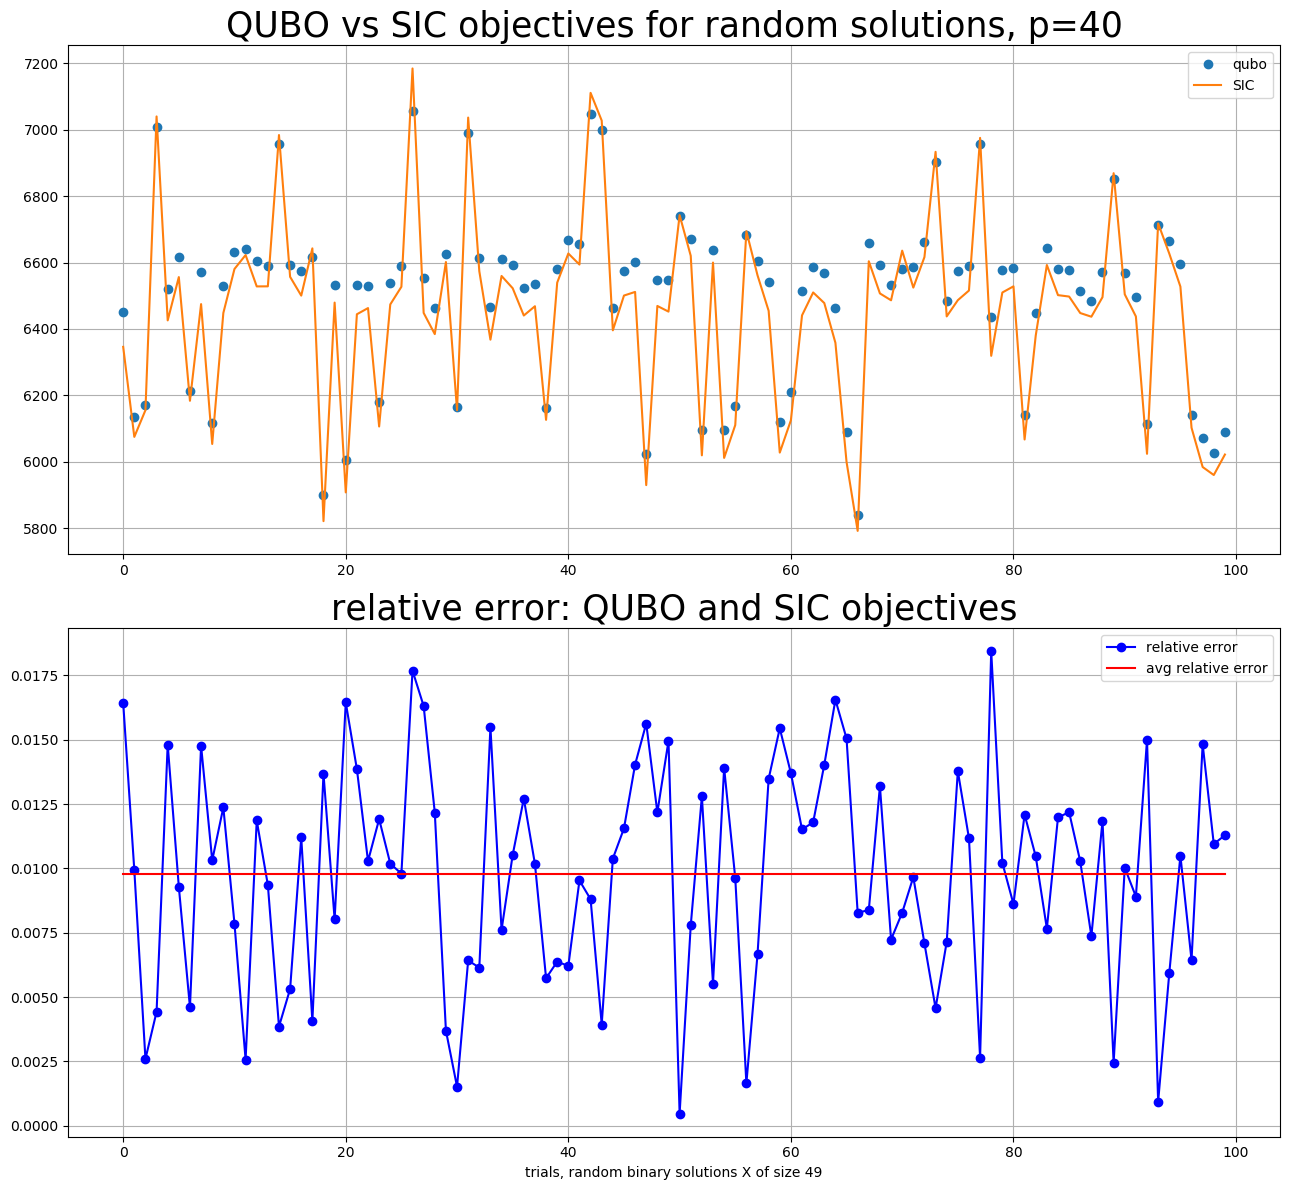

In [16]:
import dimod
F = 0
p = 5
alpha = 1
beta = 1

trials = 100    # numbe of random soluions to try
n = 9    # stops to remove

sic_obj_values = np.zeros(trials)
qubo_obj_values = np.zeros(trials)


for i in range(trials):
    used_indices = []
    count = 0
    X = np.ones(49)
    np.random.seed()
    # change X so that it has n zeros
    while count < n:
        # do not alter the last 46,47,48,49 stops
        rand_idx = np.random.randint(0,46)
        if rand_idx not in used_indices:
            used_indices.append(rand_idx)
            X[rand_idx] = 0
            count += 1
            
    assert(np.sum(X) == 49-n)
    sic_obj_values[i] = alt_obj_func(X, stops, alpha, beta)
    lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta)

    bqm = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
    qubo_obj_values[i] = bqm.energy(X)


rel_dif = np.abs(qubo_obj_values-sic_obj_values)/sic_obj_values
avg_rel_error = np.average(rel_dif)
print('AVG relative error percent QUBO and SIC:', '{:4.2f}%'.format(avg_rel_error*100))
DPI=100
FONTSIZE=25
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(13,12)
fig.set_dpi(DPI)
axs[0].set_title(f'QUBO vs SIC objectives for random solutions, p={49-n}', fontsize=FONTSIZE)
axs[0].plot(qubo_obj_values, 'o')
axs[0].plot(sic_obj_values)
# axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].legend(['qubo', 'SIC'])
axs[1].grid(True)
axs[1].set_title('relative error: QUBO and SIC objectives', fontsize=FONTSIZE)
axs[1].plot(rel_dif, '-ob')
axs[1].plot(np.arange(0,trials), [avg_rel_error]*trials, 'r')
axs[1].set_xlabel('trials, random binary solutions X of size 49')
axs[1].legend(['relative error', 'avg relative error'])

fig.tight_layout()
plt.show()
plt.close()

### Graph layout of the objective function

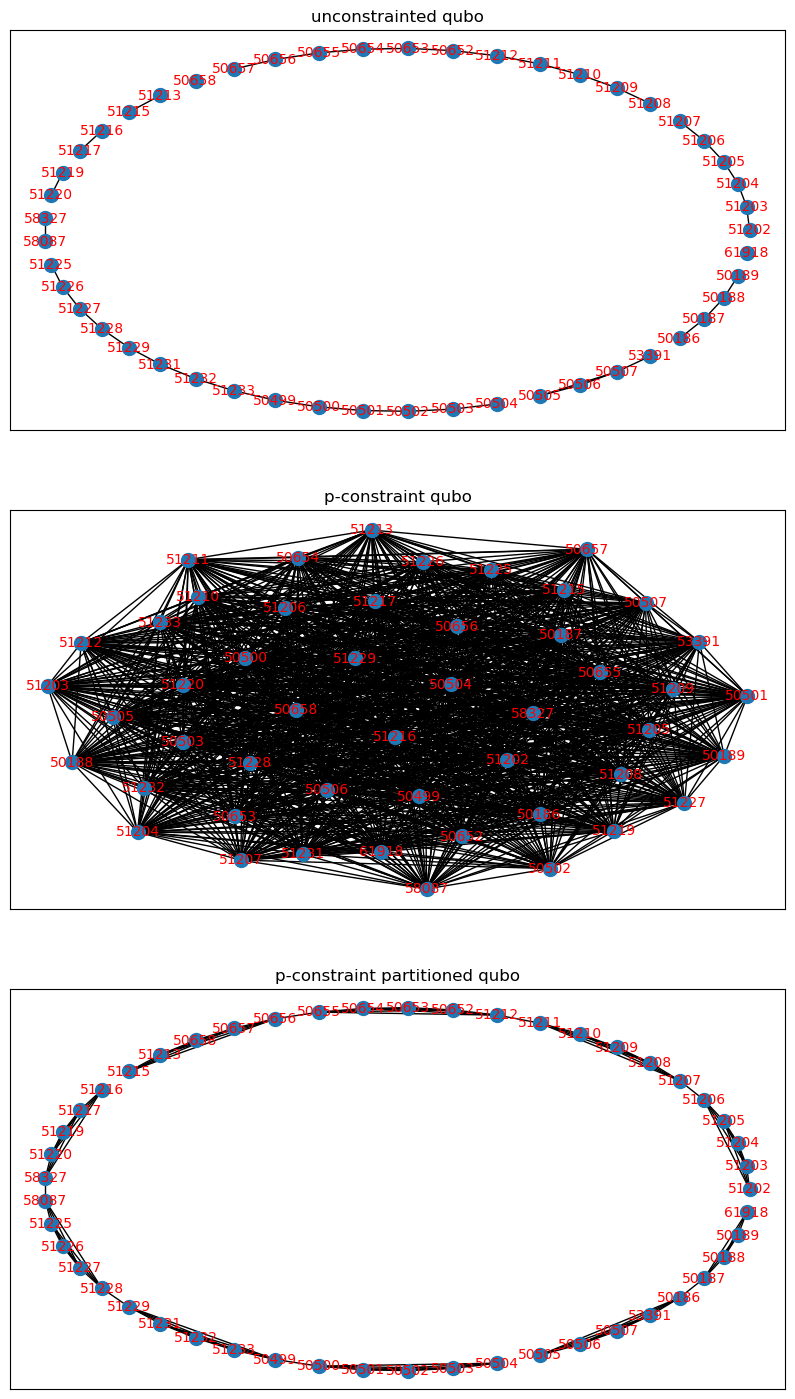

In [17]:
import networkx as nx
# no p-constraint
lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta, p_constraint=False)
bqm_no_constraint = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_no_const = bqm_no_constraint.to_networkx_graph()

# with p-constraint, dense graph
lin, quad, offset = qubo_taylor_obj(stops,F, p, alpha, beta, p_constraint=True)
bqm_dense = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_dense = bqm_dense.to_networkx_graph()

# with sparse p-constraint
lin, quad, offset = qubo_taylor_sparse_obj(stops,F, p, alpha, beta)
bqm_sparse_constraint = dimod.BinaryQuadraticModel(lin, quad, 0, dimod.BINARY)
G_sparse_const = bqm_sparse_constraint.to_networkx_graph()

vert_labels = {}
for stop in stops:
    vert_labels[stop.j] = stop.id

fig, axs = plt.subplots(3, 1)
fig.set_size_inches(10,18)
fig.set_dpi(DPI)
axs[0].set_title('unconstrainted qubo')
axs[1].set_title('p-constraint qubo')
axs[2].set_title('p-constraint partitioned qubo')

pos = nx.shell_layout(G_no_const, scale=10)

nx.draw_networkx(G_no_const, pos=pos, node_size=100, ax=axs[0], labels=vert_labels, font_size=10, font_color='r')
nx.draw_networkx(G_dense, node_size=100, ax=axs[1], labels=vert_labels, font_size=10, font_color='r')
nx.draw_networkx(G_sparse_const, pos=pos, node_size=100, ax=axs[2], labels=vert_labels, font_size=10, font_color='r')



### Find a solution using D-Wave SA solver

In [18]:
import neal
# determine penalty F for p-constraint
F = 0
p = 4    # number of bus stops to keep in the batch
# create bqm with no constraint and get its max energy
lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=5, p_constraint=False)
unconstrained_bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)
unconstrained_bqm_energy = unconstrained_bqm.energy(np.ones(49))
print('energy unconstrained for X = 1,1,...,1:', unconstrained_bqm_energy)


# determine penalty F fo p-constraint
F = 0.01*unconstrained_bqm_energy
print('penlty term F:', F)
# init a proper bqm with constraint and F
lin, quad, offset = qubo_taylor_sparse_obj(stops, F, p, alpha, beta, batch=5, p_constraint=True)
bqm = dimod.BinaryQuadraticModel(lin, quad, offset, dimod.BINARY)

# normalize
# bqm.normalize()

# scale so min becomes max
bqm.scale(-1)
sampler = neal.SimulatedAnnealingSampler()

# sample 1000 times
solution = 0
optimal_value = 0
for i in range(1000):
    sampleSet = sampler.sample(bqm)
    X = np.array([value for value in sampleSet.first[0].values()])
    
    if sampleSet.first[1] < optimal_value:
        optimal_value = sampleSet.first[1]
        solution = X
        
# check out solution feasibility
bqm.scale(-1)
# check the value of the constraint
penalty_value = bqm.energy(solution) - unconstrained_bqm.energy(solution)
obj_value = bqm.energy(solution) - penalty_value
print('penalty value at X*:', penalty_value)
print('obj value with constrained subtracted at X*:', obj_value)
print('unconstrained obj value at X*:', unconstrained_bqm.energy(solution))
# check the solution on the SIC stop oriented objective
sic_optimal = alt_obj_func(solution, stops, alpha, beta)
print('\n################ SA RESULT ################')
print('TOTAL REMAINING STOPS:', np.sum(solution))
print('OPTIMAL ENERGY AT X*:',bqm.energy(solution))
print('SOLUTION X*:', solution)
print('SIC OPTIMAL AT X*:', sic_optimal)



energy unconstrained for X = 1,1,...,1: 6640.374316051069
penlty term F: 66.4037431605107
penalty value at X*: -5.4569682106375694e-12
obj value with constrained subtracted at X*: 7152.031819799762
unconstrained obj value at X*: 7152.031819799762

################ SA RESULT ################
TOTAL REMAINING STOPS: 40
OPTIMAL ENERGY AT X*: 7152.031819799757
SOLUTION X*: [1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1]
SIC OPTIMAL AT X*: 7218.3908153349275


### Build the model using GEKKO 

In [ ]:
from gekko import GEKKO
uniqueRouteAreas = list(uniqueRouteAreas)

# store solutions in solutions list
solutions = []

# for p in [10, 20, 30, 40, 45]:
for p in [40]:

    print(f'Working on p = {p}')
    m = GEKKO() # Initialize gekko
    m.options.SOLVER=1  # APOPT is an MINLP solver

    # optional solver settings with APOPT
    m.solver_options = ['minlp_maximum_iterations 10000', \
                        # minlp iterations with integer solution
                        'minlp_max_iter_with_int_sol 1000', \
                        # treat minlp as nlp
                        'minlp_as_nlp 0', \
                        # nlp sub-problem max iterations
                        'nlp_maximum_iterations 1000', \
                        # 1 = depth first, 2 = breadth first
                        'minlp_branch_method 1', \
                        # maximum deviation from whole number
                        'minlp_integer_tol 0.1', \
                        # covergence tolerance
                        'minlp_gap_tol 0.01']




    numAreas = len(uniqueRouteAreas)
    numStops = 10 # possible maximum of number of stops
    totalNumStops = len(stops)

    # Initialize optimization vector X
    X = []
    for i in range(0, totalNumStops):
        randVal = np.round(np.random.rand(1))[0]
        x = m.Var(value=randVal,lb=0,ub=1, integer=True)
        X.append(x)

    # Matrix S_ij
    S_ij = m.Array(m.Var,(numAreas, numStops))

    # Populate matrix S_ij
    for i in range(0,numAreas):
        area = uniqueRouteAreas[i]
        nbSize = len(area.neighborhood)
        # for each stop in the Nb of the area
        for j in range(0, nbSize):
            stop = area.neighborhood[j]
            denom = m.Intermediate(1)
            
            # build denominator
            for compet in stop.competitors:
#                 w = m.Const(compet.weight**alpha)
#                 dist = m.Const(d(compet, area)**(-beta))
#                 denom += m.Intermediate(w*dist*X[compet.j])
                denom += X[compet.j]
            
            w = m.Const(stop.weight**alpha)
            dist = m.Const(d(stop, area)**(-beta))
            demand = m.Const(area.pop)
            S_ij[i,j] = m.Intermediate(demand*w*dist*X[stop.j]/denom)

        # fill the rest of columns with zeros
        for k in range(j+1, numStops):
            S_ij[i,k] = 0

    f = m.sum(S_ij)
    # Constraint
    m.Equation(m.sum(X) == p)
    # Objective func
    m.Obj(-f)
    m.solve(disp=False) # Solve
    XX = [int(x[0]) for x in X]
    f_max = abs(m.options.objfcnval)
    print('Objection func max:', f_max)
    solutions.append([p, XX, f_max])

# append solution for all 49 stops North bound dir
solutions.append([49, [1]*49, obj_func(np.ones(49), uniqueRouteAreas, alpha, beta)])
solution_csv_name = f'solutions-a{alpha}-b{beta}-r{competDist}.csv'
import json
# write out the solution to json
with open(solution_csv_name, 'w', encoding='utf-8') as f:
    json.dump(solutions, f, ensure_ascii=False, indent=4)



In [ ]:
# load linear objective solution
lin_sol_json = 'solutions-a1-b1-r0.0001.csv'
with open(lin_sol_json) as f:
    loaded_solns_linear = json.load(f)

# load non-linear objective solution
nonlin_sol_json = 'solutions-a1-b1-r0.3.csv'
with open(nonlin_sol_json) as f:
    loaded_solns_nonlinear = json.load(f)

In [ ]:
plt.figure(num=None, figsize=(10, 4), dpi=300, facecolor='w', edgecolor='k')
p_vs_val_linear = np.array([(sol[0], sol[2]) for sol in loaded_solns_linear])
p_vs_val_nonlinear = np.array([(sol[0], sol[2]) for sol in loaded_solns_nonlinear])

plt.plot(p_vs_val_linear[:,0], p_vs_val_linear[:,1], '-o')
plt.plot(p_vs_val_nonlinear[:,0], p_vs_val_nonlinear[:,1], '-o')

plt.xlabel('p = No. of stops')
plt.ylabel('SIC value')
plt.legend(['N_j radius 0km. Objective linear', 'N_j radius 0.3km. Objective non-lin' ])
plt.title('Optimal SIC values for different p values.', fontsize=20)




In [ ]:
# Bubble map on default map box
import plotly.express as px
import plotly.graph_objects as go
token = open("plotly-key").read()

fig = px.scatter_mapbox(areaVizDf, lat="lat", lon="long",
                            size="pop",
                            hover_name="areaId",
                            hover_data=['areaId'],
                            size_max=25,
                            center=dict(lat=49.25308, lon=-123.0687), #Center it on the middle of the bus route
                            zoom=11,
                            width=700,
                            height=1000
                            )

fig.update_traces(
    marker=dict(opacity=0, # opacity of areas
                color="blue" # Color of areas
               ) 
)

fig3 =  go.Figure(go.Scattermapbox(
        name = "Bus Stops",
        lat=stopVizDf["lat"],
        lon=stopVizDf["long"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=7,
            color='red', # color of bus stops
     
       
        ),
        text=stopVizDf["stopId"],
    ))

areasTrace =  go.Figure(go.Scattermapbox(
        name = "Areas",
        lat=areaVizDf["lat"],
        lon=areaVizDf["long"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=areaVizDf['pop']/50,
            color='blue', # color of bus stops
            opacity=0.2

       
        ),
        text=areaVizDf["areaId"],
    ))

fig.update_layout(
                  # Default style is "light"
                  mapbox_style="light",# Comment this out to revert to default map
                  mapbox_accesstoken=token,
                  title="Demand nodes and facilities",
                  margin=dict(l=15, r=2, t=30, b=15),
                    ) # close layout update

fig.add_trace(fig3.data[0])
fig.add_trace(areasTrace.data[0])
fig.show()

The plot below is produced using standard matplotlib tools

In [ ]:


sns.set(style="darkgrid")

mapImg = plt.imread('map.png')
bounds = {'long-min':-123.1339,'long-max': -123.0251,'lat-min': 49.2039, 'lat-max':49.2902}
box = [bounds['long-min'],bounds['long-max'],bounds['lat-min'],bounds['lat-max']]
height = box[3] - box[2]
width = box[1] - box[0]
aspect = width/height
print(width, height)

fig, ax = plt.subplots(figsize = (10,15), dpi=300)


ax.scatter(areaVizDf['long'], areaVizDf['lat'], zorder=1, alpha= 0.1, c='b', s=areaVizDf['pop']/2)
ax.scatter(stopVizDf['long'], stopVizDf['lat'], zorder=1, c='r', s=20)


ax.set_title('Plotting Spatial Data')

ax.set_xlim(bounds['long-min'],bounds['long-max'])
ax.set_ylim(bounds['lat-min'],bounds['lat-max'])

ax.imshow(mapImg, zorder=0, extent = box, interpolation='nearest', aspect='auto')
fig.show()